### Классификация rte

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet

     |████████████████████████████████| 325 kB 13.8 MB/s 
     |████████████████████████████████| 134 kB 71.3 MB/s 
     |████████████████████████████████| 1.1 MB 61.6 MB/s 
     |████████████████████████████████| 212 kB 70.5 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 56.0 MB/s 
     |████████████████████████████████| 144 kB 51.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 13.8 MB/s 
     |████████████████████████████████| 6.5 MB 53.0 MB/s 
     |████████████████████████████████| 895 kB 49.3 MB/s 
     |████████████████████████████████| 5

In [2]:
from datasets import load_dataset
dataset = load_dataset('glue', 'rte')

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

Посмотрим на предложения в датасете

In [ ]:
dataset['train']['sentence1'][:5], dataset['train']['sentence2'][:5]

(['No Weapons of Mass Destruction Found in Iraq Yet.',
  'A place of sorrow, after Pope John Paul II died, became a place of celebration, as Roman Catholic faithful gathered in downtown Chicago to mark the installation of new Pope Benedict XVI.',
  'Herceptin was already approved to treat the sickest breast cancer patients, and the company said, Monday, it will discuss with federal regulators the possibility of prescribing the drug for more breast cancer patients.',
  'Judie Vivian, chief executive at ProMedica, a medical service company that helps sustain the 2-year-old Vietnam Heart Institute in Ho Chi Minh City (formerly Saigon), said that so far about 1,500 children have received treatment.',
  "A man is due in court later charged with the murder 26 years ago of a teenager whose case was the first to be featured on BBC One's Crimewatch. Colette Aram, 16, was walking to her boyfriend's house in Keyworth, Nottinghamshire, on 30 October 1983 when she disappeared. Her body was later fo

Представим эмбеддинги предложений как сумму эмбеддингов слов, из которых они состоят. Так мы можем сравнить состав предложений. Такой способ не будет учитывать порядка слов, подчинение слов, но можно попробовать определять является ли предложение следствием другого так.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopWords = set(stopwords.words('english'))

wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    return " ".join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

In [ ]:
!pip install fasttext --quiet

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
embeddings_pretrained = fasttext.load_model('cc.en.300.bin')

In [ ]:
for t in ['train', 'validation', 'test']:
    t_dataset = dataset[t]

    embeddings1 = []
    embeddings2 = []

    for data in t_dataset:
        sent1, sent2 = data['sentence1'], data['sentence2']

        sent1 = preproc_nltk(sent1)
        sent2 = preproc_nltk(sent2)

        emb1 = embeddings_pretrained.get_sentence_vector(sent1)
        emb2 = embeddings_pretrained.get_sentence_vector(sent2)

        embeddings1.append(emb1)
        embeddings2.append(emb2)

    dataset[t] = dataset[t].add_column('embedding1', embeddings1)
    dataset[t] = dataset[t].add_column('embedding2', embeddings2)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'embedding1', 'embedding2'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'embedding1', 'embedding2'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'embedding1', 'embedding2'],
        num_rows: 3000
    })
})

In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset['train'], batch_size=128, shuffle=False)
val_loader = DataLoader(dataset['validation'], batch_size=128, shuffle=False)

Возьмем в качестве признаков 2 эмбеддинга предложений 

In [ ]:
import numpy as np

def get_X_y(dataset):
    embeddings = []
    labels = []

    for data in dataset:
        emb1, emb2, label = data['embedding1'], data['embedding2'], data['label']

        embeddings.append(emb1 + emb2)
        labels.append(label)
    return np.array(embeddings), np.array(labels)

X_train, y_train = get_X_y(dataset['train'])
X_val, y_val = get_X_y(dataset['validation'])

### Логистическая регрессия

In [4]:
from sklearn.metrics import f1_score

def evaluate_metrics(preds, correct):
    print('Accuracy:', (correct == preds).mean())
    print('F1 score:', f1_score(correct, preds))

In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_val)
evaluate_metrics(preds, y_val)

NameError: ignored

### Полносвязная нейросеть

In [5]:
import torch
from torch import nn, optim

def get_fc(in_dim, out_dim, p):
    torch.manual_seed(1)

    model = nn.Sequential(
        nn.Linear(in_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(256, out_dim)
    )

    return model

In [6]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from tqdm import tqdm
from IPython.display import clear_output


def train_fc(model, optimizer, criterion, scheduler, loader, 
                num_epochs=1, freq=10, device='cuda'):
    i = 0
    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []

        model.train()
        for data in tqdm(loader):
            text = torch.cat((torch.stack(data['embedding1']), 
                              torch.stack(data['embedding2']))).to(torch.float).to(device).t()
            
            labels = data['label'].to(device)

            outputs = model(text)

            loss = criterion(outputs, labels)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            scheduler.step()

            if i % freq == 0:
                clear_output()
                plt.plot(train_losses)
                plt.show()


def evaluate_fc(model, loader, device='cuda'):
    preds = []
    correct = []

    model.eval()
    with torch.no_grad():
        for data in loader:
            text = torch.cat((torch.stack(data['embedding1']), 
                              torch.stack(data['embedding2']))).to(torch.float).to(device).t()
            
            labels = data['label'].to(device)

            outputs = model(text)

            preds += outputs.argmax(axis=1)
            correct += labels

    correct = torch.tensor(correct).cpu()
    preds = torch.tensor(preds).cpu()

    print('Accuracy:', (correct == preds).to(torch.float).mean().item())
    print('F1 score:', f1_score(correct, preds))

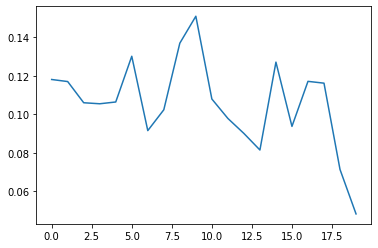

100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


In [ ]:
model = get_fc(600, 2, 0.2).to('cpu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=40)

train_fc(model, optimizer, criterion, scheduler, train_loader,
            num_epochs=10, device='cpu')

In [ ]:
evaluate_fc(model, val_loader, 'cpu')

Accuracy: 0.512635350227356
F1 score: 0.509090909090909


Попробуем взять эмбеддинги из трансформеров

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def get_model_and_tokenizer(name):
    torch.manual_seed(1)
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=2)

    for param in model.parameters():
        param.requires_grad = False

    if name.startswith("distilbert"):
        for param in model.pre_classifier.parameters():
            param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model, tokenizer

In [8]:
def train_model(model, tokenizer, optimizer, criterion, scheduler, loader, 
                num_epochs=1, freq=10, device='cuda'):
    i = 0
    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []

        model.train()
        for data in tqdm(loader):
            text = [s1 + " [ENTAILMENT] " + s2 for s1, s2 in zip(data['sentence1'], data['sentence2'])]
            encoded_input = tokenizer(text, return_tensors='pt', padding=True, 
                                      max_length = 252, truncation=True).to(device)

            labels = data['label'].to(device)

            outputs = model(**encoded_input).logits

            loss = criterion(outputs, labels)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            scheduler.step()

            if i % freq == 0:
                clear_output()
                plt.plot(train_losses)
                plt.show()


def evaluate_model(model, tokenizer, loader, device='cuda'):
    preds = []
    correct = []

    model.eval()
    with torch.no_grad():
        for data in loader:
            text = [s1 + " [ENTAILMENT] " + s2 for s1, s2 in zip(data['sentence1'], data['sentence2'])]
            encoded_input = tokenizer(text, return_tensors='pt', padding=True, 
                                      max_length = 256, truncation=True).to(device)

            labels = data['label'].to(device)
            outputs = model(**encoded_input).logits

            preds += outputs.argmax(axis=1)
            correct += labels

    correct = torch.tensor(correct).cpu()
    preds = torch.tensor(preds).cpu()

    print('Accuracy:', (correct == preds).to(torch.float).mean().item())
    print('F1 score:', f1_score(correct, preds))

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### BERT

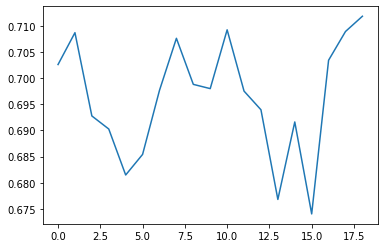

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


In [12]:
model, tokenizer = get_model_and_tokenizer('bert-base-uncased')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=15)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader,
            num_epochs=5, freq=3)

In [13]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.5667870044708252
F1 score: 0.4174757281553398


### RoBERTa

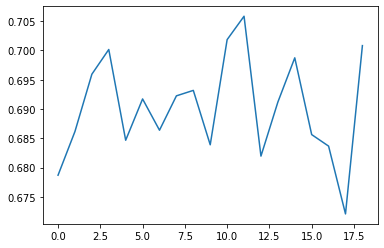

100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


In [14]:
model, tokenizer = get_model_and_tokenizer('roberta-large')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=15)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader,
            num_epochs=5, freq=3)

In [15]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.505415141582489
F1 score: 0.3964757709251101


Лучший результат показала логистическая регрессия на сумме эмбеддингов слов - 57% accuracy. Попробуем улучшить его

In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0, 0.1, 1, 10]}

logreg = LogisticRegression(random_state=0)
clf = GridSearchCV(logreg, parameters)
clf.fit(X_train, y_train)

NameError: ignored